In [1]:
import google.generativeai as genai
from dotenv import load_dotenv  
import os
load_dotenv()

# Configuramos nuestra instancia del modelo con nuestra API key
GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')

genai.configure(api_key = GOOGLE_API_KEY)

# Listamos todos los modelos disponibles que tenemos por medio del API
for model in genai.list_models():
    print(model.name)

/home/nelson/Desktop/personal/atom/challange/code/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TypeError: Model.__init__() got an unexpected keyword argument 'thinking'

In [3]:
# Creamos la instancia del modelo en gemeni
model = genai.GenerativeModel(model_name="models/gemini-2.5-flash-lite")

In [4]:
# Hacemos un request al API
response = model.generate_content("¿Qué es la ciencia de datos? Explica brevemente.")

# Observamos la respuesta
print(response.text)

La **ciencia de datos** es un campo interdisciplinario que utiliza métodos científicos, procesos, algoritmos y sistemas para **extraer conocimiento y perspectivas valiosas de los datos**, en sus diversas formas (estructurados y no estructurados).

En resumen, se trata de **entender los datos para tomar mejores decisiones**. Combina conocimientos de matemáticas, estadística, informática y el dominio específico del problema que se está abordando.


In [5]:
from typing import TypedDict, List
from dotenv import load_dotenv
from langchain_core.messages import HumanMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, START, END
import os

load_dotenv()  # loads GOOGLE_API_KEY from .env

class AgentState(TypedDict):
    messages: List[HumanMessage]

# Pick a Gemini model (good free tier): gemini-2.5-flash or gemini-2.5-flash-lite
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash-lite",  # or "gemini-2.5-flash", "gemini-2.5-pro"
    temperature=0,
)

def process(state: AgentState) -> AgentState:
    response = llm.invoke(state["messages"])
    print(f"\nAI: {response.content}")
    return state  # keep state shape the same

graph = StateGraph(AgentState)
graph.add_node("process", process)
graph.add_edge(START, "process")
graph.add_edge("process", END)
agent = graph.compile()

user_input = input("Enter: ")
while user_input != "exit":
    agent.invoke({"messages": [HumanMessage(content=user_input)]})
    user_input = input("Enter: ")


/home/nelson/Desktop/personal/atom/challange/code/.venv/lib/python3.10/site-packages/langchain_google_genai/chat_models.py:2330: UserWarning: HumanMessage with empty content was removed to prevent API error
  warnings.warn(


ChatGoogleGenerativeAIError: Invalid argument provided to Gemini: 400 * GenerateContentRequest.contents: contents is not specified


In [33]:
from typing import Annotated, Sequence, TypedDict
from dotenv import load_dotenv  
from langchain_core.messages import BaseMessage, HumanMessage # The foundational class for all message types in LangGraph
from langchain_core.messages import ToolMessage # Passes data back to LLM after it calls a tool such as the content and the tool_call_id
from langchain_core.messages import SystemMessage # Message for providing instructions to the LLM
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langchain_google_genai import ChatGoogleGenerativeAI
import sqlite3

# Exportamos las variables de entorno
load_dotenv()

# Creamos el estado del agente
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]


In [34]:
# Tools de Agente
@tool
def agregar(a: int, b:int):
    """Esta es una función que agrega dos números"""
    return a + b

@tool
def restar(a: int, b: int):
    """Esta es una función que resta dos números"""
    return a - b

@tool
def query_tool(query: str):
    """Herramienta para hacer consultas a la base de datos, la información que acepta el tool es un SQL query
    La estructura de la tabla llamada ventas es la siguiente:
    id INTEGER PRIMARY KEY,
    producto TEXT NOT NULL,
    categoria TEXT NOT NULL,
    precio REAL NOT NULL,
    pais TEXT NOT NULL,
    fecha_venta DATE NOT NULL
    """
    # Se conecta a la base de datos
    conn = sqlite3.connect('ventas.db')
    cursor = conn.cursor()
    
    # Ejectuta el query realizado por el agente
    cursor.execute(query)
    rows = cursor.fetchall()

    return rows

# Se crea la lista de tools
#tools = [agregar, restar, query_tool]
tools = [query_tool]

# Se crea el modelo de LLM y se asocian los tools
model = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash-lite",  # or "gemini-2.5-flash", "gemini-2.5-pro"
    temperature=0,
    verbose=True,
).bind_tools(tools)



In [35]:
# Nodos de Agente

# Se define el contexto base del problema
base_context = '''La empresa TechNova vende productos electrónicos. Tiene un promedio de 5.000
ventas mensuales en Latinoamérica. Sus categorías principales son smartphones,
notebooks y accesorios.'''

# Nodo que llama al agente
def model_call(state:AgentState) -> AgentState:
    system_prompt = SystemMessage(
        content=(
            "Eres un asistente con acceso a un tool para hacer consultas SQL sobre la base 'ventas'. "
            "Usa el tool cuando necesites datos y luego responde al usuario con un resumen claro. "
            "Si el tool devuelve JSON, interprétalo y explica el resultado."
            "También puedes responder información sobre la empresa TechNova"
            "La empresa TechNova vende productos electrónicos. Tiene un promedio de 5.000 ventas mensuales en Latinoamérica."
            "Sus categorías principales son smartphones, notebooks y accesorios."
            
        )
    )
    response = model.invoke([system_prompt] + state["messages"])
    return {"messages": [response]}

# Nodo para ver si se finaliza el contexto
def should_continue(state: AgentState): 
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls: 
        return "end"
    else:
        return "continue"

In [36]:
# Estructura del graph

# Estado
graph = StateGraph(AgentState)

# Nodos
graph.add_node("our_agent", model_call)
tool_node = ToolNode(tools=tools)
graph.add_node("tools", tool_node)

# Edgees
graph.set_entry_point("our_agent")
graph.add_conditional_edges(
    "our_agent",
    should_continue,
    {
        "continue": "tools",
        "end": END,
    },
)
graph.add_edge("tools", "our_agent")

# Se compila el graph
app = graph.compile()


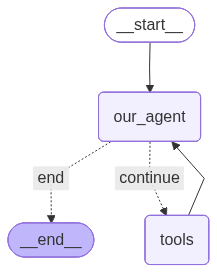

In [37]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [38]:
# Función para visualizar de mejor manera los resultados
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()
            
# Se pide la información al usuario
#input_user = input("Enter: ")
#inputs = {"messages": [HumanMessage(content=input_user)]}  # <-- HumanMessage
#print_stream(app.stream(inputs, stream_mode="values"))
#
input_user = input("Enter: ")
while input_user != "exit":
    inputs = {"messages": [(input_user)]}
    print_stream(app.stream(inputs, stream_mode="values"))
    input_user = input("Enter: ")


================================ Human Message =================================

¿Cuál fue el precio promedio de venta en Chile?
================================== Ai Message ==================================
Tool Calls:
  query_tool (8fb4bdd0-7d88-45e2-b3bc-b3c2f0d8924c)
 Call ID: 8fb4bdd0-7d88-45e2-b3bc-b3c2f0d8924c
  Args:
    query: SELECT AVG(precio) FROM ventas WHERE pais = "Chile"
================================= Tool Message =================================
Name: query_tool

[[1800.0]]
================================== Ai Message ==================================

El precio promedio de venta en Chile fue de 1800.
================================ Human Message =================================




/home/nelson/Desktop/personal/atom/challange/code/.venv/lib/python3.10/site-packages/langchain_google_genai/chat_models.py:2330: UserWarning: HumanMessage with empty content was removed to prevent API error
  warnings.warn(


ChatGoogleGenerativeAIError: Invalid argument provided to Gemini: 400 * GenerateContentRequest.contents: contents is not specified
